# Random Forest from the scratch (using dataset Adult from UCI)

A modifield version of a modifield version of:
Decision Tree from the Scratch, Rakend Dubba (Computational Engineer | Data Scientist).
*Source:* https://medium.com/@rakendd/decision-tree-from-scratch-9e23bcfb4928.


1) Using Bagging, get a group of $N_B$ random samples ($x_i, i = 1,... ,N_B$) with replacement for each three, for all $M$ trees.

2) Each tree with a maximum limit of $s_{MAX}$ splitlevels. Why there categorical features with more then two values, each level may have more then two nodes.

3) Each tree receive $K = s_{MAX}$ random features from all $p$ features.

4) There are two alternatives for splitting with numeric features: using entropy criteria and random splitting between max/min values. For categorical features, all values receive a node.

5) The ensembling model is based in voting, may possible to use both majority or soft. The schoice is made when using the predict funcion.

In [2]:
import numpy as np
import pandas as pd
eps = np.finfo(float).eps
from numpy import log2 as log
from anytree import Node, RenderTree
from anytree import search as anys
from anytree.exporter import DotExporter
from IPython.display import Image

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


##### Load dataset:

In [3]:
n_samples = 40
n_samples_test = n_samples*1
features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status",
            "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
            "Hours per week", "Country", "Target"]
train_data = pd.read_csv(
    #"https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    "adult.data",
    names=features,
    sep=r'\s*,\s*',
    engine='python',
    na_values="?").dropna()



test_data = pd.read_csv(
    #"https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
    "adult.test_fix",
    names=features,
    sep=r'\s*,\s*',
    skiprows=[0],
    engine='python',
    na_values="?").dropna()

Target = 'Target'
Labels = train_data.Target.unique()
counts = train_data.Target.value_counts()
print(counts)
print(int(100*counts.min()/n_samples))

def amostra_dados(dados):
    dados2 = dados.loc[dados[Target]==Labels[0]].sample(int(n_samples/2))
    dados2 = dados2.append(dados.loc[dados[Target]==Labels[1]].sample(int(n_samples/2)), ignore_index=True).reset_index(drop=True)
    return dados2

train_data = amostra_dados(train_data)
test_data = amostra_dados(test_data)

counts = train_data.Target.value_counts()
print(counts)
print(int(100*counts.min()/n_samples))


def formata_dados(dados):
    for chave in dados.keys():
        if not np.issubdtype(dados[chave].dtype, np.number):
            dados[chave] = dados[chave].astype(str)
        elif (len(dados[chave].unique())<5):
            dados[chave] = dados[chave].astype(str)
    return dados

train_data = formata_dados(train_data)
test_data = formata_dados(test_data)

<=50K    22654
>50K      7508
Name: Target, dtype: int64
18770
<=50K    20
>50K     20
Name: Target, dtype: int64
50


In [110]:
def find_entropy(df):
    entropy = 0
    values = df[Target].unique()
    for value in values:
        temp = df[Target].value_counts()[value]/len(df[Target])
        entropy += -temp*np.log2(temp)
    return entropy

def find_entropy_attribute(df,attribute):
    
    if not np.issubdtype(df[attribute].dtype, np.number):   
        return find_entropy_attribute_not_number(df,attribute), None
    else:
        return find_entropy_attribute_number(df,attribute)
          
        
def find_entropy_attribute_not_number(df,attribute):
    target_variables = df[Target].unique()  #This gives all 'Yes' and 'No'
    variables = df[attribute].unique()    #This gives different features in that attribute (like 'Hot','Cold' in Temperature)
    entropy2 = 0
    for variable in variables:
        entropy = 0
        for target_variable in target_variables:
            num = len(df[attribute][df[attribute]==variable][df[Target] ==target_variable])
            den = len(df[attribute][df[attribute]==variable])
            fraction = num/(den+eps)
            entropy += -fraction*log(fraction+eps)
        entropy2 += -(den/len(df))*entropy
    return abs(entropy2)


def find_entropy_attribute_number(df,attribute):
    target_variables = df[Target].unique()  #This gives all 'Yes' and 'No'
    variables = df[attribute].unique()    #This gives different features in that attribute (like 'Hot','Cold' in Temperature)
    variables.sort()
    if len(variables)>2:
        variables = variables[1:-1]
        vk3 = variables[0]
        entropy3 = 0
    else:
        vk3 = variables[0]
        entropy3 = np.Inf
    
    for vk in variables:
        entropy = 0
        for target_variable in target_variables:
            num = len(df[attribute][df[attribute]<=vk][df[Target] ==target_variable])
            den = len(df[attribute][df[attribute]<=vk])
            fraction = num/(den+eps)
            entropy += -fraction*log(fraction+eps)
        for target_variable in target_variables:
            num = len(df[attribute][df[attribute]>vk][df[Target] ==target_variable])
            den = len(df[attribute][df[attribute]>vk])
            fraction = num/(den+eps)
            entropy += -fraction*log(fraction+eps)
        entropy2 = (den/len(df))*abs(entropy)
        #print(str(entropy2)+"|"+str(vk))
        if entropy2>entropy3:
            entropy3 = entropy2
            vk3 = vk
    return abs(entropy3),vk3

def find_winner(df):
    IG = []
    vk = list()
    for key in df.columns.difference([Target]):
        temp,temp2 = find_entropy_attribute(df,key)
        vk.append(temp2)
        IG.append(find_entropy(df)-temp)
    return df.columns.difference([Target])[np.argmax(IG)], vk[np.argmax(IG)]

def buildtree(df,tree=None, mytree=None, T_pro=0.1, T_pro_num=0.4):
    
    def ramificatree(Thd):
        if (len(clValue)==1):
            tree[node][value] = clValue[0]
            print(node +' : '+value+' : '+clValue[0])
        else:
            rel_counts = counts.min() / counts.max()
            if (rel_counts<Thd):
                tree[node][value] = clValue[counts.argmax()]
                print(node +' : '+value+' : '+clValue[counts.argmax()])
            else:
                tree[node][value] = buildtree(subtable)
                print(node +' : '+value+' : *')

    #print(find_winner(df))
    #formata_dados(dados)
    node,vk = find_winner(df)

    if tree is None:
        tree={}
        tree[node] = {}

    if vk is None:
        attValue = np.unique(df[node])
        for value in attValue:

            subtable = df[df[node] == value].reset_index(drop=True)
            clValue,counts = np.unique(subtable[Target],return_counts=True)

            ramificatree(T_pro)
    else:
        
        if (len(df[node][df[node] <= vk].unique())>0) and (len(df[node][df[node] > vk].unique())>0):
           
            # >vk
            value = node+' >'+str(vk)
            subtable = df[df[node] > vk].rename(columns = {node:value}).reset_index(drop=True)
            clValue,counts = np.unique(subtable[Target],return_counts=True)            
            if (len(subtable[value].unique())==1) and (len(clValue)>1):
                clValue = clValue[counts.argmax()]
                tree[node][value] = clValue[0]
                print(node +' : '+value+' : '+clValue[0])
            else:
                ramificatree(T_pro_num)
            clValue_antes = clValue[0]
            value_antes = value
            # <=vk
            value = node+' <='+str(vk)
            subtable = df[df[node] <= vk].rename(columns = {node:value}).reset_index(drop=True)
            clValue,counts = np.unique(subtable[Target],return_counts=True)
            if ((len(subtable[value].unique())==1) and (len(clValue)>1)):
                tree[node][value] = clValue[counts.argmax()]
                print(node +' : '+value+' : '+clValue[counts.argmax()])
            else:
                ramificatree(T_pro_num)

        else:
            df[node] = df[node].astype(str)
            buildtree(df)
        
    return tree


# Only to see

def print_tree(arg):
    for pre, fill, node in RenderTree(arg):
        print("%s%s" % (pre, node.name))
        
def converte_para_anytree(tree,node=None,mytree=None):
    
    if node is None:
        temp = list(tree.keys())
        node = temp[0]
        mytree = {}
        mytree[node] = Node(node)
        converte_para_anytree(tree,node,mytree)
    else:
        tree = tree[node]
        if not isinstance(tree, str):
            childs = list(tree.keys())
            for child in childs:
                if ((tree[child] == Labels[0]) or (tree[child] == Labels[1])):
                    temp = mytree[node]
                    mytree[child] = Node(child, parent=temp, target=tree[child])
                else:
                    temp = mytree[node]
                    mytree[child] = Node(child, parent=temp)
                    converte_para_anytree(tree,child,mytree)
        else:
            mytree[node] = 'Fim'
                
    return mytree

#anys.findall_by_attr(mytree['Taste'], name="target", value='Yes')

def mostra_tree(tree):
    mytree = converte_para_anytree(tree)

    temp = list(tree.keys())
    root = temp[0]
    mytree[root]

    for pre, fill, node in RenderTree(mytree[root]):
        txt_node = str(node)
        if  Labels[0] in txt_node:
            print("%s%s" % (pre, node.name+': '+Labels[0]))
        elif Labels[1] in txt_node:
            print("%s%s" % (pre, node.name+': '+Labels[1]))
        else:
            print("%s%s" % (pre, node.name))
    
    
def mostra_tree_graph(tree, largura=None, altura=None):
    mytree = converte_para_anytree(tree)

    temp = list(tree.keys())
    root = temp[0]
    mytree[root]
    DotExporter(mytree[root]).to_picture("tree.png")
    return Image(filename='tree.png', width=largura, height=altura) 


def predict(inst,tree):

    for node in tree.keys():     

        if ('<=' in str(tree[node].keys())):

            childs = list(tree[node].keys())

            if ('<=' in childs[1]):
                temp = childs[1]
                childs[1] = childs[0]
                childs[0] = temp

            vk = float(childs[1].split('>')[1])
            valor = float(str(inst[node]))
            if (valor > vk):
                tree = tree[node][childs[1]]
                prediction = None
                if type(tree) is dict:
                    prediction = predict(inst, tree)
                else:
                    prediction = tree
                    break;
            else:
                tree = tree[node][childs[0]]
                prediction = None
                if type(tree) is dict:
                    prediction = predict(inst, tree)
                else:
                    prediction = tree
                    break;
            
        else:
            value = inst[node]
            if value in tree[node].keys():
                tree = tree[node][value]
                prediction = None
                if type(tree) is dict:
                    prediction = predict(inst, tree)
                else:
                    prediction = tree
                    break;
            else:
                prediction = 'Not exists node.'
        
    return prediction

def test_step(arg,tree):
    S = 0
    for i in range(0,len(arg)):
        S += (predict(arg.iloc[i],tree) == arg.iloc[i].Target)*1

    print(S / len(arg))

In [7]:
tree = None
tree = buildtree(train_data,T_pro = 0.2)

Capital Loss : Capital Loss >1485 : >50K
Capital Gain : Capital Gain >7430 : >50K
Education : Bachelors : <=50K
Education : HS-grad : >50K
Occupation : Adm-clerical : *
Occupation : Craft-repair : >50K
Occupation : Exec-managerial : >50K
Occupation : Farming-fishing : >50K
Occupation : Handlers-cleaners : <=50K
Occupation : Machine-op-inspct : <=50K
Occupation : Other-service : <=50K
Occupation : Priv-house-serv : <=50K
Education : Assoc-acdm : <=50K
Education : Masters : >50K
Education : Prof-school : >50K
Occupation : Prof-specialty : *
Occupation : Sales : <=50K
Relationship : Husband : <=50K
Relationship : Own-child : <=50K
Relationship : Wife : >50K
Occupation : Tech-support : *
Occupation : Transport-moving : <=50K
Capital Gain : Capital Gain <=7430 : *
Capital Loss : Capital Loss <=1485 : *


In [8]:
tree

{'Capital Loss': {'Capital Loss <=1485': {'Capital Gain': {'Capital Gain <=7430': {'Occupation': {'Adm-clerical': {'Education': {'Bachelors': '<=50K',
        'HS-grad': '>50K'}},
      'Craft-repair': '>50K',
      'Exec-managerial': '>50K',
      'Farming-fishing': '>50K',
      'Handlers-cleaners': '<=50K',
      'Machine-op-inspct': '<=50K',
      'Other-service': '<=50K',
      'Priv-house-serv': '<=50K',
      'Prof-specialty': {'Education': {'Assoc-acdm': '<=50K',
        'Masters': '>50K',
        'Prof-school': '>50K'}},
      'Sales': '<=50K',
      'Tech-support': {'Relationship': {'Husband': '<=50K',
        'Own-child': '<=50K',
        'Wife': '>50K'}},
      'Transport-moving': '<=50K'}},
    'Capital Gain >7430': '>50K'}},
  'Capital Loss >1485': '>50K'}}

In [9]:
mostra_tree(tree)

Capital Loss
├── Capital Loss >1485: >50K
└── Capital Loss <=1485
    └── Capital Gain
        ├── Capital Gain >7430: >50K
        └── Capital Gain <=7430
            └── Occupation
                ├── Adm-clerical
                │   └── Education
                │       ├── Bachelors: <=50K
                │       └── HS-grad: >50K
                ├── Craft-repair: >50K
                ├── Exec-managerial: >50K
                ├── Farming-fishing: >50K
                ├── Handlers-cleaners: <=50K
                ├── Machine-op-inspct: <=50K
                ├── Other-service: <=50K
                ├── Priv-house-serv: <=50K
                ├── Prof-specialty
                │   └── Education
                │       ├── Assoc-acdm: <=50K
                │       ├── Masters: >50K
                │       └── Prof-school: >50K
                ├── Sales: <=50K
                ├── Tech-support
                │   └── Relationship
                │       ├── Husband: <=50K
                │

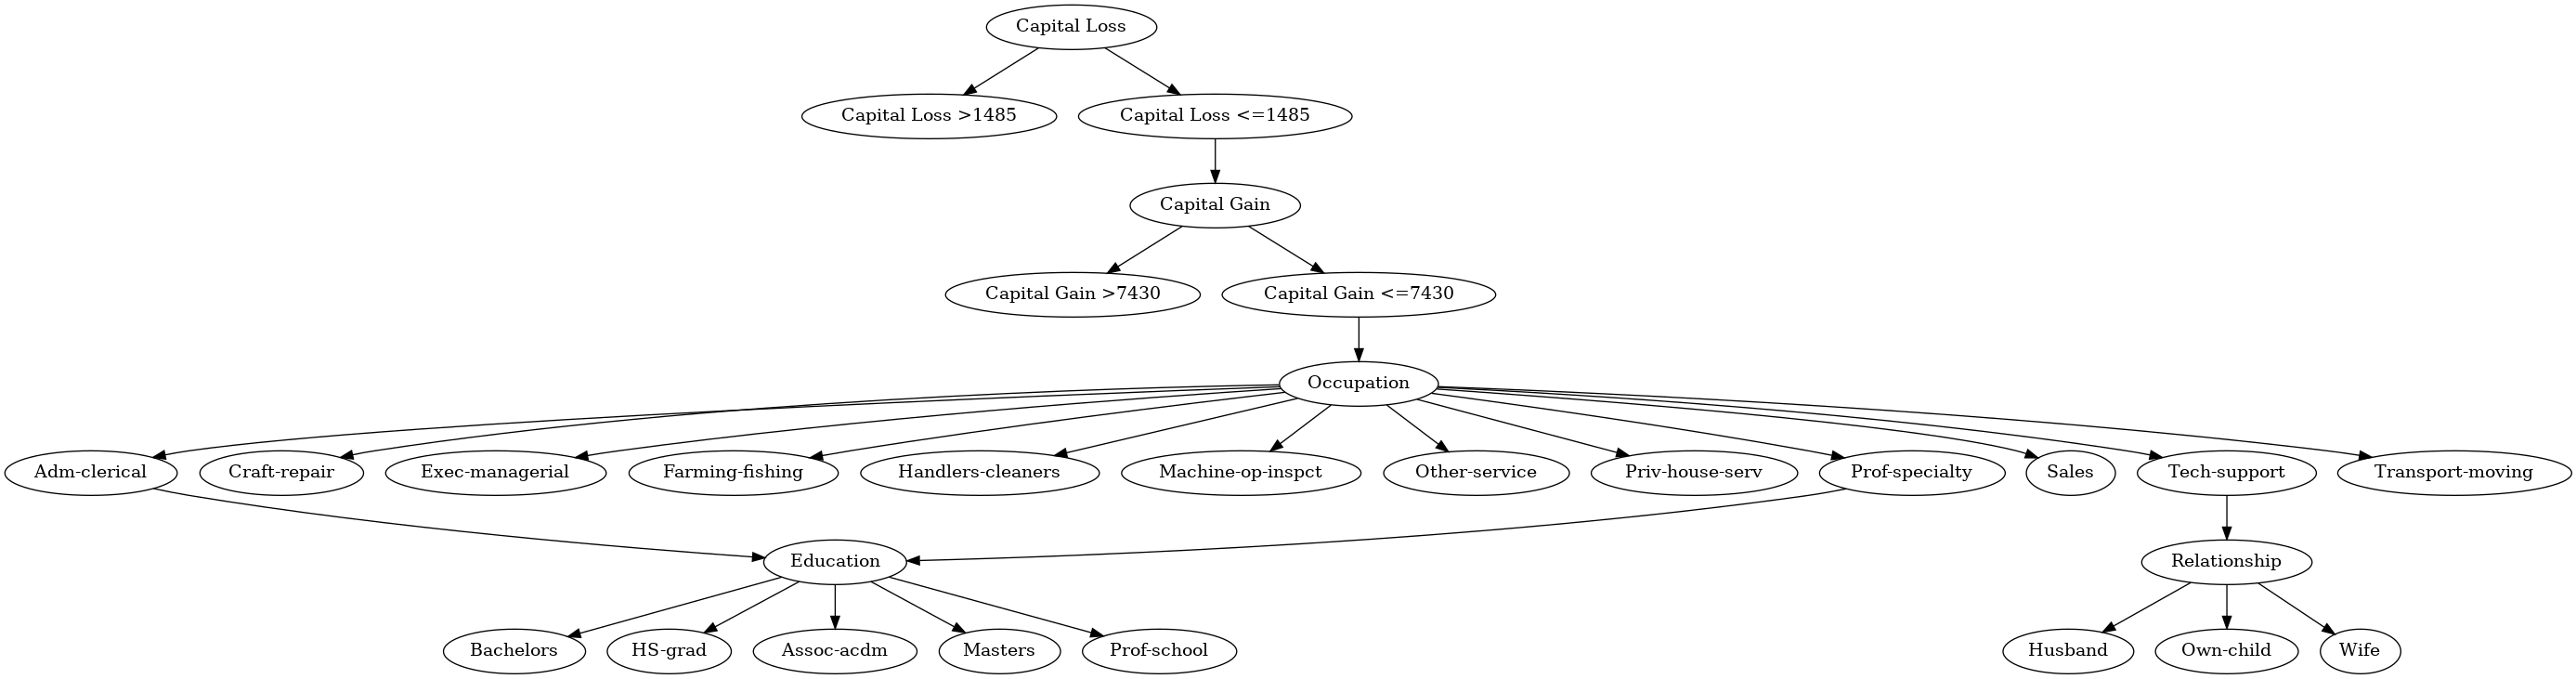

In [10]:
mostra_tree_graph(tree)

In [13]:
test_step(test_data,tree)

0.0


In [108]:
predict(test_data.loc[0],tree)

'<=50K'

In [109]:
test_data[Target].loc[0]

'<=50K'

In [111]:
test_step(test_data,tree)

0.55
